In [ ]:
from tensorflow.keras.datasets import cifar10
from google.colab import files
import numpy as np, cv2, matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import tqdm
import io
from PIL import Image


In [ ]:
(x_train, y_train), _ = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
y_train = y_train.flatten()

print("Training data shape:", x_train.shape)
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training data shape: (50000, 32, 32, 3)


In [ ]:
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0,180,0,256,0,256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_lbp_features(image, num_points=24, radius=8):
    gray = cv2.cvtColor((image * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    lbp = local_binary_pattern(gray, num_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, num_points + 3),
                             range=(0, num_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_combined_features(image):
    color_feat = extract_color_histogram(image)
    texture_feat = extract_lbp_features(image)
    return np.hstack([color_feat, texture_feat])


In [ ]:
N = 5000
features = []
for img in tqdm(x_train[:N], desc="Extracting CIFAR-10 features"):
    features.append(extract_combined_features(img))
features = np.array(features)
print("Feature matrix shape:", features.shape)


Extracting CIFAR-10 features: 100%|██████████| 5000/5000 [00:06<00:00, 722.03it/s]

Feature matrix shape: (5000, 538)


Saving Screenshot 2025-10-27 115843.png to Screenshot 2025-10-27 115843.png


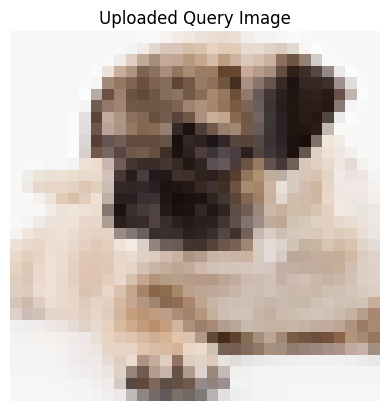

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[fn])).convert('RGB')
    img = img.resize((32, 32))
    user_img = np.array(img) / 255.0
    plt.imshow(user_img)
    plt.title("Uploaded Query Image")
    plt.axis('off')
    plt.show()


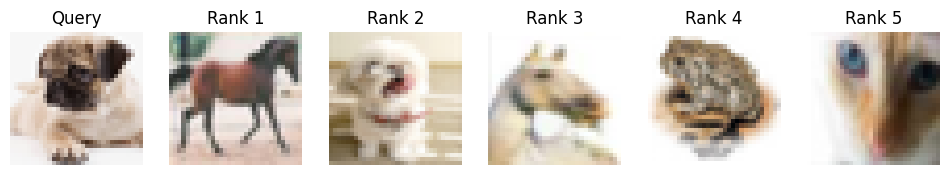

In [ ]:
def retrieve_similar_images(query_image, top_k=5):
    query_feat = extract_combined_features(query_image).reshape(1, -1)
    dists = euclidean_distances(query_feat, features)[0]
    idxs = np.argsort(dists)[:top_k]
    return idxs, dists[idxs]

idxs, dists = retrieve_similar_images(user_img, top_k=5)

plt.figure(figsize=(12,3))
plt.subplot(1,6,1)
plt.imshow(user_img)
plt.title("Query")
plt.axis('off')

for i, idx in enumerate(idxs):
    plt.subplot(1,6,i+2)
    plt.imshow(x_train[idx])
    plt.title(f"Rank {i+1}")
    plt.axis('off')

plt.show()
